In [1]:
import warnings
warnings.filterwarnings("ignore")

from pandas import read_csv
from pandas import datetime
from pandas import DataFrame

from math import sqrt

from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

In [2]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

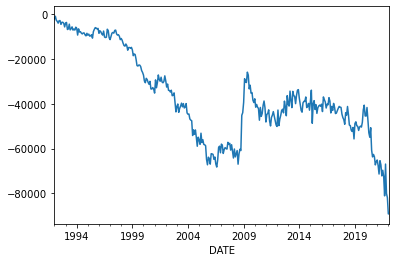

In [3]:
series = read_csv('BOPGSTB.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series.plot()
plt.show()

In [4]:
# # Subtracting the Trend Component
# result_mul = seasonal_decompose(df['BOPGSTB'], model = 'additive', extrapolate_trend = 'freq')
# series = df.values.reshape(-1)
# detrended = series - result_mul.trend.values
# plt.plot(df.index, detrended)
# plt.title('Detrended Time Series', fontsize = 12)
# plt.xlabel('Date')
# plt.ylabel('Trade Balance (in Millions of $)')
# plt.show()

In [5]:
# transform = log(series*-1)*-1

# plt.plot(df.index, transform)
# plt.title('Log-transformed Plot', fontsize = 12)
# plt.xlabel('Date')
# plt.ylabel('Log Trade Balance')
# plt.show()

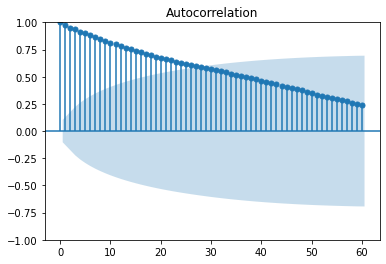

In [6]:
# Autocorrelation Function
plot_acf(series, lags=60); # => Series isn't stationary

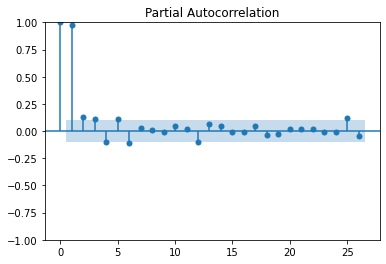

In [7]:
# Partial Autocorrelation Fucntion
plot_pacf(series);

### ACF is slow decay -> AR or ARMA
### PACF has no trend, just p-significant lags -> AR model

In [8]:
series.index = series.index.to_period('M')

In [9]:
model = ARIMA(series, order=(7,0,0))
model_fit = model.fit()

print(model_fit.summary())

# Only first 4 lags are significant

                               SARIMAX Results                                
Dep. Variable:                BOPGSTB   No. Observations:                  362
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -3410.307
Date:                Mon, 02 May 2022   AIC                           6838.614
Time:                        22:19:16   BIC                           6873.639
Sample:                    01-31-1992   HQIC                          6852.538
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.693e+04   2.26e+04     -1.636      0.102   -8.12e+04    7311.598
ar.L1          0.6862      0.040     17.291      0.000       0.608       0.764
ar.L2          0.2264      0.052      4.354      0.0

In [10]:
model = ARIMA(series, order=(4,0,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                BOPGSTB   No. Observations:                  362
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -3411.857
Date:                Mon, 02 May 2022   AIC                           6835.714
Time:                        22:19:16   BIC                           6859.064
Sample:                    01-31-1992   HQIC                          6844.997
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.693e+04   3.34e+04     -1.105      0.269   -1.02e+05    2.86e+04
ar.L1          0.7072      0.036     19.804      0.000       0.637       0.777
ar.L2          0.2104      0.047      4.441      0.0

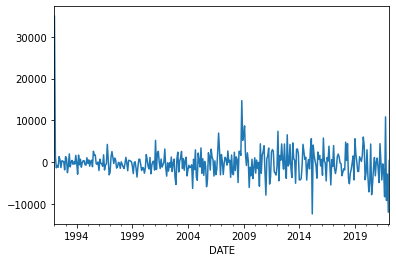

In [11]:
residuals = DataFrame(model_fit.resid)
residuals.plot(legend=False)
plt.show()

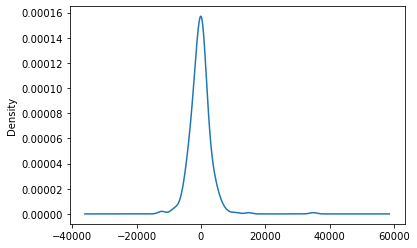

In [12]:
residuals.plot(kind='kde', legend=False)
plt.show()

In [13]:
# summary stats of residuals
print(residuals.describe())

                  0
count    362.000000
mean    -185.602962
std     3493.971715
min   -12402.652030
25%    -1809.996606
50%     -150.487567
75%     1158.003782
max    34903.309392


In [14]:
X = series
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# Clearly, p-value > 0.05 => Series is non-stationary

ADF Statistic: -0.322179
p-value: 0.922304
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


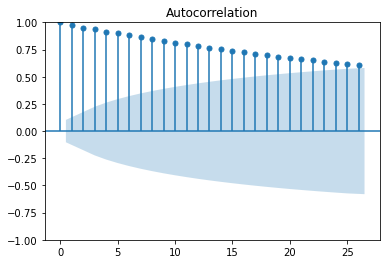

In [15]:
plot_acf(X);

# More than 10 lags show positive decaying autocorrelation
# => Series is non-stationary

In [16]:
X = X.diff().dropna()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# Clearly, p-value < 0.05 => Series has now become stationary
# One-differencing (d = 1) required for ARIMA model

ADF Statistic: -10.442180
p-value: 0.000000
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


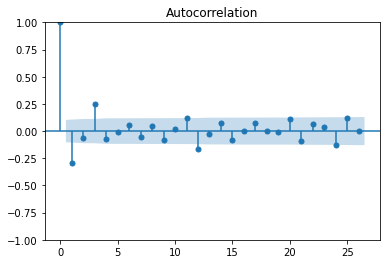

In [17]:
plot_acf(X);

# Clearly a stationary series now

In [18]:
model = ARIMA(series, order=(4,1,0))
model_fit = model.fit()

print(model_fit.summary())

# 4th lag becomes insignificant now, let's remove and see if AIC/BIC reduces

                               SARIMAX Results                                
Dep. Variable:                BOPGSTB   No. Observations:                  362
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -3398.862
Date:                Mon, 02 May 2022   AIC                           6807.724
Time:                        22:19:17   BIC                           6827.168
Sample:                    01-31-1992   HQIC                          6815.455
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3094      0.038     -8.042      0.000      -0.385      -0.234
ar.L2         -0.0711      0.041     -1.719      0.086      -0.152       0.010
ar.L3          0.2366      0.040      5.908      0.0

In [19]:
model = ARIMA(series, order=(3,1,0))
model_fit = model.fit()

print(model_fit.summary())

# A better model

                               SARIMAX Results                                
Dep. Variable:                BOPGSTB   No. Observations:                  362
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -3399.948
Date:                Mon, 02 May 2022   AIC                           6807.897
Time:                        22:19:17   BIC                           6823.452
Sample:                    01-31-1992   HQIC                          6814.082
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2935      0.036     -8.141      0.000      -0.364      -0.223
ar.L2         -0.0810      0.041     -1.990      0.047      -0.161      -0.001
ar.L3          0.2107      0.036      5.798      0.0

In [20]:
X = series.values
size = int(len(X) * 0.66)

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=-44922.751865, expected=-47460.000000
predicted=-46656.348644, expected=-49473.000000
predicted=-49725.404275, expected=-50126.000000
predicted=-50560.594247, expected=-42780.000000
predicted=-44458.453064, expected=-49749.000000
predicted=-48917.107972, expected=-46842.000000
predicted=-45136.608548, expected=-45106.000000
predicted=-47473.009569, expected=-42941.000000
predicted=-42584.700407, expected=-42406.000000
predicted=-42074.796752, expected=-44030.000000
predicted=-43173.365691, expected=-38794.000000
predicted=-39586.271263, expected=-41467.000000
predicted=-41490.137655, expected=-45332.000000
predicted=-43115.097900, expected=-36334.000000
predicted=-38777.457718, expected=-40135.000000
predicted=-40790.933872, expected=-41004.000000
predicted=-38063.086931, expected=-34314.000000
predicted=-36851.817382, expected=-38487.000000
predicted=-38133.048783, expected=-41701.000000
predicted=-38730.298318, expected=-34426.000000
predicted=-37165.279529, expected=-36356

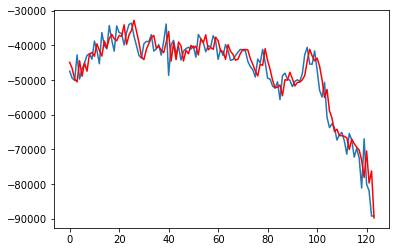

In [21]:
# Plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()